In [52]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import constants as const, units as u

import growpacity as op

In [53]:
# provide optool optional arguments (eg. composition)
# optool_args = '-p 0.5' # for example
optool_args = '' # default
OC = op.OpacityCalculator(amax_min=0.1*u.um, amax_max=10*u.um, Namax=5, # 2 bins per decade
                           T_min=1*u.K, T_max=3000*u.K, NT=101, # good enough
                           q_min=-4.5, q_max=-2.5, Nq=9, # every 0.25 -> resolves exactly for -3, -3.75, -3.5
                           optool_args=optool_args, dirc='data/')

In [54]:
# if you want to just use the default dataset, first unzip default-data.zip in this folder
# (you should have a folder called 'default-data') and then run this without changes
OC = op.OpacityCalculator(amax_min=0.1*u.um, amax_max=1*u.m, Namax=15, # 2 bins per decade
                           T_min=1*u.K, T_max=10000*u.K, NT=301,
                           q_min=-4.5, q_max=-2.5, Nq=9, # every 0.25 -> resolves exactly for -3, -3.75, -3.5
                           optool_args='', dirc='default-data/')

In [55]:
# call optool to compute the opacities for each a_max and q and store them in separate files.
# larger a_max takes longer, and for this dataset the largest grain size is 1 um.
# So this will take a while. Maybe run it overnight. But you will already have practically enough data
# to compute opacities up to ~1cm within an hour.

# If you're using the default dataset, this should finish immediately!
# If in that case you still see output, something is wrong.
OC.execute_optool(quiet=True)

In [56]:
# The class now can read all that optool output. Use it to compute Rosseland and Planck means.
# The Rosseland mean includes scattering with the Henyey & Greenstein (1941) approach (g factor).
# Files are output in the same folder as the frequency-dependent opacity data.
OC.build_mean_opacities(overwrite=True)

In [57]:
# now load it all from the disk into 3D arrays of q, a_max, T and then store the 3D arrays
OC.compute_and_store_master_arrays(overwrite=True)

In [58]:
# now load that 3D data
kR_arr, kP_arr = OC.load_master_arrays()

In [59]:
q    = OC.q
amax = OC.amax.to_value('cm')
T    = OC.T.to_value('K')
arrs = (q, amax, T)

def where(arr, v): return np.argmin(np.abs(arr-v))

# make sure the interpolation arrays include the raw datapoints to properly compare later
def combined(arr1, arr2): return np.unique(np.sort(np.concatenate((arr1, arr2))))

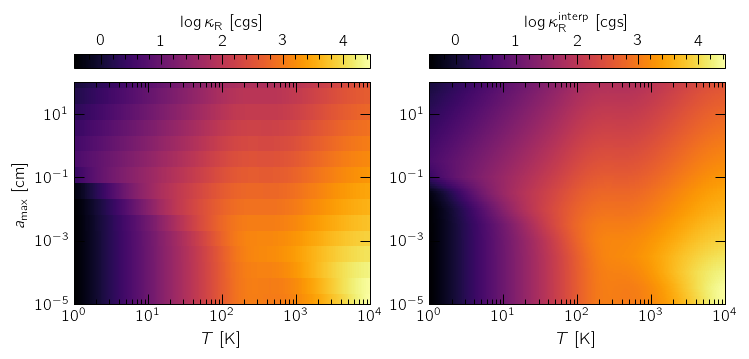

In [60]:
# interpolate in amax-T space

a_interp = combined(np.geomspace(amax.min(), amax.max(), 120), amax)
T_interp = combined(np.geomspace(T.min(), T.max(), 2000), T)
q_interp = q[where(q, -3.65)]

kR_interp_aT = op.evaluate_mean_opacities(q, amax, T, kR_arr, q_interp, a_interp, T_interp)[0]
kP_interp_aT = op.evaluate_mean_opacities(q, amax, T, kP_arr, q_interp, a_interp, T_interp)[0]

fig, ax = plt.subplots(ncols=2, dpi=120, figsize=(7, 3))

idx  = where(q, q_interp)

qty = np.log10(kR_arr[idx])
plotargs = dict(vmin=qty.min(), vmax=qty.max(), cmap=plt.cm.inferno)
img0 = ax[0].pcolormesh(T, amax, qty, **plotargs)
img1 = ax[1].pcolormesh(T_interp, a_interp, np.log10(kR_interp_aT), **plotargs)

for axis in ax:
    axis.loglog()
    axis.set_ylim(1e-5, 1e2)
    axis.set_xlim(1, 10000)
    axis.set_xlabel(r'$T$ [K]')

ax[0].set_ylabel(r'$a_\text{max}$ [cm]')

plt.colorbar(img0, ax=ax[0], location='top', orientation='horizontal').set_label(r'$\log\kappa_\mathrm{R}$ [cgs]')
plt.colorbar(img1, ax=ax[1], location='top', orientation='horizontal').set_label(r'$\log\kappa_\mathrm{R}^\mathrm{interp}$ [cgs]')

plt.show()
plt.close()

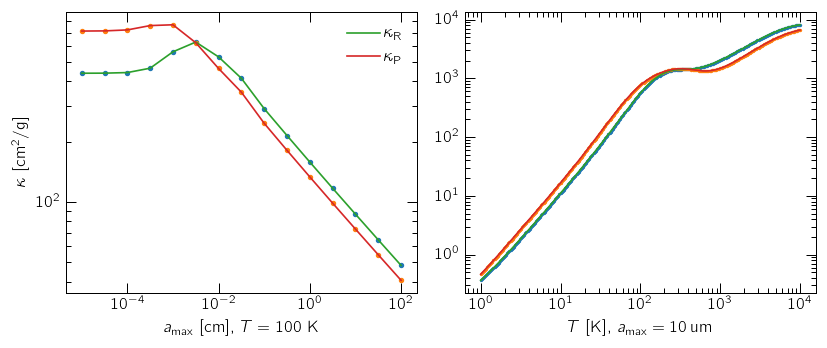

In [61]:
fig, ax = plt.subplots(ncols=2, dpi=120, figsize=(7, 3))

idx = where(q, q_interp)
T_  = T[where(T, 100)]
amax_ = amax[where(amax, 1e-3)] # 10 microns

ax[0].scatter(amax, kR_arr[idx, :, where(T, T_)], s=5, c='C0')
ax[0].plot(a_interp, kR_interp_aT[:, where(T_interp, T_)], label=r'$\kappa_\text{R}$', c='C2')
ax[0].scatter(amax, kP_arr[idx, :, where(T, T_)], s=5, c='C1')
ax[0].plot(a_interp, kP_interp_aT[:, where(T_interp, T_)], label=r'$\kappa_\text{P}$', c='C3')

ax[1].scatter(T, kR_arr[idx, where(amax, amax_), :], s=1, c='C0')
ax[1].plot(T_interp, kR_interp_aT[where(a_interp, amax_)], c='C2')

ax[1].scatter(T, kP_arr[idx, where(amax, amax_), :], s=1, c='C1')
ax[1].plot(T_interp, kP_interp_aT[where(a_interp, amax_)], c='C3')

for axis in ax: axis.set_yscale('log')
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[0].legend()

ax[0].set_ylabel(r'$\kappa$ [cm${}^2$/g]')
ax[0].set_xlabel(r'$a_\text{max}$ [cm], $T=%g$ K'%T_)
ax[1].set_xlabel(r'$T$ [K], $a_\text{max} = %g$\,um'%(1e4*amax_))

fig.tight_layout()

plt.show()

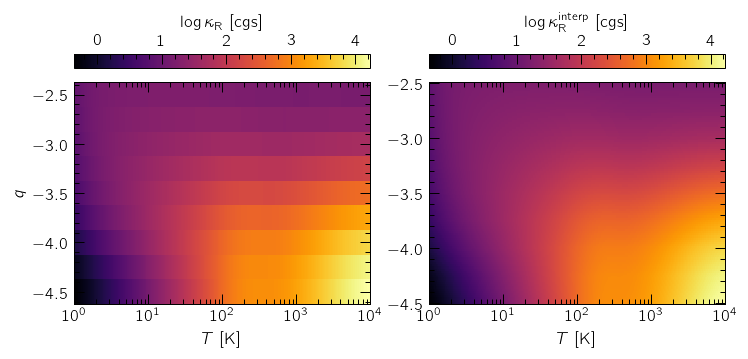

In [62]:
# interpolate in q-T space

a_interp = amax[where(amax, 0.1)] # 1 mm
T_interp = combined(np.geomspace(T.min(), T.max(), 2000), T)
q_interp = combined(np.linspace(q.min(), q.max(), 100), q)

kR_interp_qT = op.evaluate_mean_opacities(q, amax, T, kR_arr, q_interp, a_interp, T_interp)[:,0]
kP_interp_qT = op.evaluate_mean_opacities(q, amax, T, kP_arr, q_interp, a_interp, T_interp)[:,0]

fig, ax = plt.subplots(ncols=2, dpi=120, figsize=(7, 3))

idx = where(amax, a_interp)

qty = np.log10(kR_arr[:,idx])
plotargs = dict(vmin=qty.min(), vmax=qty.max(), cmap=plt.cm.inferno)
img0 = ax[0].pcolormesh(T, q, qty, **plotargs)
img1 = ax[1].pcolormesh(T_interp, q_interp, np.log10(kR_interp_qT), **plotargs)

for axis in ax:
    axis.set_xscale('log')
    axis.set_xlim(1, 10000)
    axis.set_xlabel(r'$T$ [K]')

ax[0].set_ylabel(r'$q$')

plt.colorbar(img0, ax=ax[0], location='top', orientation='horizontal').set_label(r'$\log\kappa_\mathrm{R}$ [cgs]')
plt.colorbar(img1, ax=ax[1], location='top', orientation='horizontal').set_label(r'$\log\kappa_\mathrm{R}^\mathrm{interp}$ [cgs]')

plt.show()

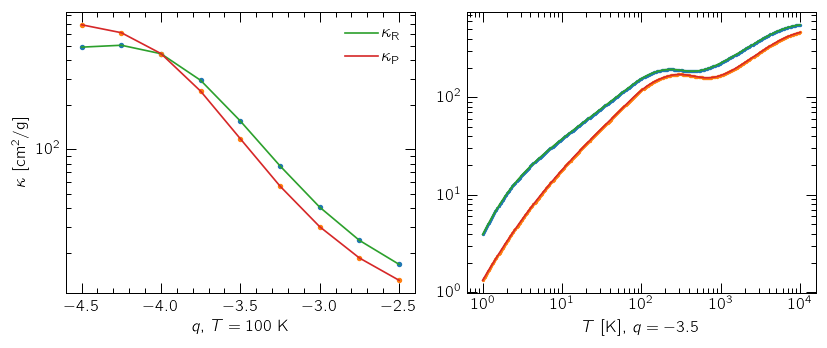

In [63]:
fig, ax = plt.subplots(ncols=2, dpi=120, figsize=(7, 3))

idx = where(amax, a_interp)
T_  = T[where(T, 100)]
q_  = q[where(q, -3.5)]

ax[0].scatter(q, kR_arr[:, idx, where(T, T_)], s=5, c='C0')
ax[0].plot(q_interp, kR_interp_qT[:, where(T_interp, T_)], label=r'$\kappa_\text{R}$', c='C2')
ax[0].scatter(q, kP_arr[:, idx, where(T, T_)], s=5, c='C1')
ax[0].plot(q_interp, kP_interp_qT[:, where(T_interp, T_)], label=r'$\kappa_\text{P}$', c='C3')

ax[1].scatter(T, kR_arr[where(q, q_), idx], s=1, c='C0')
ax[1].plot(T_interp, kR_interp_qT[where(q_interp, q_)], c='C2')
ax[1].scatter(T, kP_arr[where(q, q_), idx], s=1, c='C1')
ax[1].plot(T_interp, kP_interp_qT[where(q_interp, q_)], c='C3')

for axis in ax: axis.set_yscale('log')
ax[1].set_xscale('log')
ax[0].legend()

ax[0].set_ylabel(r'$\kappa$ [cm${}^2$/g]')
ax[0].set_xlabel(r'$q$, $T=%g$ K'%T_)
ax[1].set_xlabel(r'$T$ [K], $q=%g$'%q_)

fig.tight_layout()

plt.show()

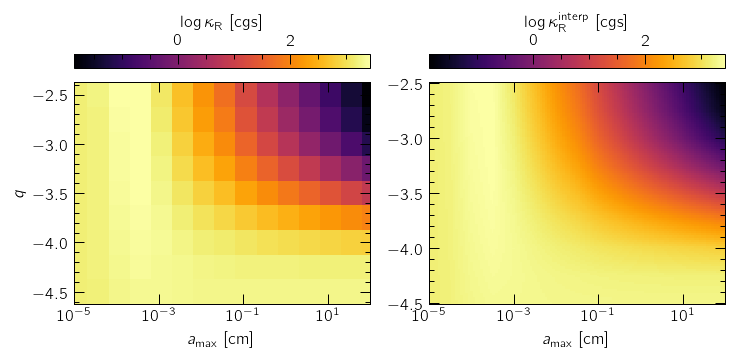

In [64]:
# interpolate in q-amax space

a_interp = combined(np.geomspace(amax.min(), amax.max(), 120), amax)
T_interp = T[where(T, 1000)]
q_interp = combined(np.linspace(q.min(), q.max(), 100), q)

kR_interp_qa = op.evaluate_mean_opacities(q, amax, T, kR_arr, q_interp, a_interp, T_interp)[:,:,0]
kP_interp_qa = op.evaluate_mean_opacities(q, amax, T, kP_arr, q_interp, a_interp, T_interp)[:,:,0]

fig, ax = plt.subplots(ncols=2, dpi=120, figsize=(7, 3))

idx = where(T, T_interp)

qty = np.log10(kR_arr[:,:,idx])
plotargs = dict(vmin=qty.min(), vmax=qty.max(), cmap=plt.cm.inferno)
img0 = ax[0].pcolormesh(amax, q, np.log10(kR_arr[:,:,idx]), **plotargs)
img1 = ax[1].pcolormesh(a_interp, q_interp, np.log10(kR_interp_qa), **plotargs)

for axis in ax:
    axis.set_xscale('log')
    axis.set_xlim(1e-5, 1e2)
    axis.set_xlabel(r'$a_\mathrm{max}$ [cm]')

ax[0].set_ylabel(r'$q$')

img0 = plt.colorbar(img0, ax=ax[0], location='top', orientation='horizontal').set_label(r'$\log\kappa_\mathrm{R}$ [cgs]')
img1 = plt.colorbar(img1, ax=ax[1], location='top', orientation='horizontal').set_label(r'$\log\kappa_\mathrm{R}^\mathrm{interp}$ [cgs]')

plt.show()

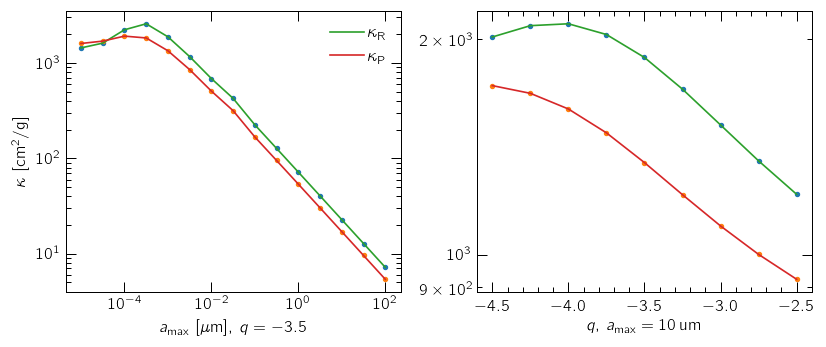

In [65]:
fig, ax = plt.subplots(ncols=2, dpi=120, figsize=(7, 3))

idx = where(T, T_interp)
q_  = q[where(q, -3.5)]
amax_ = amax[where(amax, 1e-3)] # 10 microns

ax[0].scatter(amax, kR_arr[where(q, q_), :, idx], s=5, c='C0')
ax[0].plot(a_interp, kR_interp_qa[where(q_interp, q_), :], label=r'$\kappa_\text{R}$', c='C2')
ax[0].scatter(amax, kP_arr[where(q, q_), :, idx], s=5, c='C1')
ax[0].plot(a_interp, kP_interp_qa[where(q_interp, q_), :], label=r'$\kappa_\text{P}$', c='C3')

ax[1].scatter(q, kR_arr[:, where(amax, amax_), idx], s=5, c='C0')
ax[1].plot(q_interp, kR_interp_qa[:,where(a_interp, amax_)], c='C2')
ax[1].scatter(q, kP_arr[:, where(amax, amax_), idx], s=5, c='C1')
ax[1].plot(q_interp, kP_interp_qa[:,where(a_interp, amax_)], c='C3')

for axis in ax: axis.set_yscale('log')
ax[0].set_xscale('log')
ax[0].legend()

ax[0].set_ylabel(r'$\kappa$ [cm${}^2$/g]')
ax[0].set_xlabel(r'$a_\text{max}$ [$\mu$m], $q=%g$'%q_)
ax[1].set_xlabel(r'$q$, $a_\text{max} = %g$\,um'%(amax_*1e4))

fig.tight_layout()

plt.show()

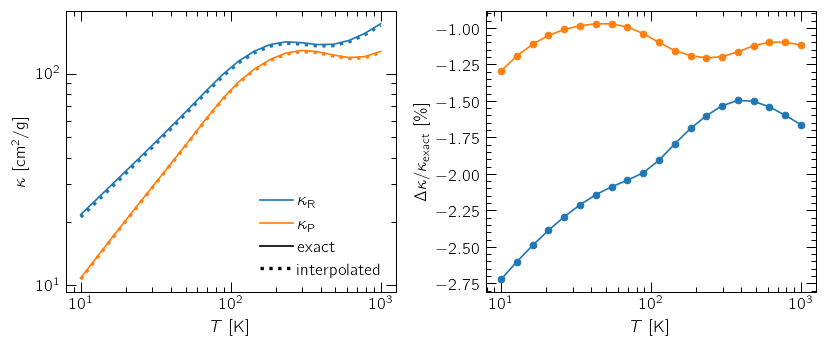

In [83]:
# compare interpolation to a true opacity

T_K = np.geomspace(10, 1000, 20)

setup = 2

if setup == 1: # small, growing dust
    kR_exact, kP_exact = op.compute_mean_opacities(T_K, 'dustkappa_a5.00e-4_q-3.20.inp')
    kR_interp = op.evaluate_mean_opacities(q, amax, T, kR_arr, -3.2, 5e-4, T_K)[0,0]
    kP_interp = op.evaluate_mean_opacities(q, amax, T, kP_arr, -3.2, 5e-4, T_K)[0,0]

elif setup == 2: # large, grown dust
    kR_exact, kP_exact = op.compute_mean_opacities(T_K, 'dustkappa_a5.00e-1_q-3.60.inp')
    kR_interp = op.evaluate_mean_opacities(q, amax, T, kR_arr, -3.6, 5e-1, T_K)[0,0]
    kP_interp = op.evaluate_mean_opacities(q, amax, T, kP_arr, -3.6, 5e-1, T_K)[0,0]

else: raise ValueError("please choose between 1 and 2 for 'setup'")
    
fig, ax = plt.subplots(ncols=2, dpi=120, figsize=(7, 3))

ax[0].plot(T_K, kR_exact.to_value('cm2/g'), c='C0', label=r'$\kappa_\text{R}$')
ax[0].plot(T_K, kP_exact.to_value('cm2/g'), c='C1', label=r'$\kappa_\text{P}$')
ax[0].plot(T_K, kR_interp, c='C0', ls=':', lw=2)
ax[0].plot(T_K, kP_interp, c='C1', ls=':', lw=2)

ax[0].plot(np.nan, np.nan, c='k', label='exact')
ax[0].plot(np.nan, np.nan, c='k', ls=':', lw=2, label='interpolated')

ax[1].plot(T_K, 100 * (kR_interp / kR_exact.to_value('cm2/g') - 1), 'o-', c='C0', ms=4)
ax[1].plot(T_K, 100 * (kP_interp / kP_exact.to_value('cm2/g') - 1), 'o-', c='C1', ms=4)

ax[0].legend()

ax[0].loglog()
ax[1].set_xscale('log')

ax[0].set_xlabel(r'$T$ [K]')
ax[1].set_xlabel(r'$T$ [K]')
ax[0].set_ylabel(r'$\kappa$ [cm${}^2$/g]')
ax[1].set_ylabel(r'$\Delta\kappa/\kappa_\text{exact}$ [\%]')

fig.tight_layout()

plt.show()